In [72]:
import numpy as np
from h5flow.data import dereference
import h5flow
import matplotlib.pyplot as plt
import glob
import mplhep as hep
import pandas as pd

from scipy.spatial.distance import cdist

flist = glob.glob('/global/cfs/cdirs/dune/users/demaross/MiniRun5_files_new_cluster/*.hdf5')
f_manager1 = h5flow.data.H5FlowDataManager(flist, 'r')

#Detector boundaries
x_boundaries = np.array([-63.931, -3.069, 3.069, 63.931])
y_boundaries = np.array([-42-19.8543, -42+103.8543]) 
z_boundaries = np.array([-64.3163,  -2.6837, 2.6837, 64.3163])


def back_track_hits(files, hits_dset_name):
    makeup_of_selection = []
    energy_ratio = []
    purity_of_muon_segments = []
    for file in files:
        print(file)
        try:
            # Load data sets
            f = h5flow.data.H5FlowDataManager(file, 'r')

            segments = f['mc_truth/segments/data']
            trajectories = f['mc_truth/trajectories/data']
            dset_hits = f['charge/'+hits_dset_name+'/data']

            track2hits = dereference(
                f['/analysis/rock_muon_tracks/data']['rock_muon_id'],     # indices of A to load references for, shape: (n,)
                f['/analysis/rock_muon_tracks/ref/charge/calib_prompt_hits/ref'],  # references to use, shape: (L,)
                f['/charge/calib_prompt_hits/data'],
                ref_direction=(0,1)  # dataset to load, shape: (M,)
            )

            # Loop through the tracks
            for hits_of_track in track2hits:
                track_makeup = {}

                trajs_of_track = []

                hits = np.array([tup for tup in hits_of_track.data if not all(np.all(elem == 0) for elem in tup)], dtype=hits_of_track.dtype)

                total_charge = np.sum(hits['Q'])
                total_energy = np.sum(hits['E'])

                hit_ref = hits['id']
                hits_bt = f['mc_truth/'+hits_dset_name[:-1]+'_backtrack/data'][hit_ref] 

                # Check if hit['id'] matches index in dset_hits_name
                indices = np.where(np.isin(dset_hits['id'], hits['id']))[0]

                for i in range(len(indices)):
                    if indices[i] != hits['id'][i]:
                        print(f'WARNING: rock_muon hit id not the same as {hits_dset_name} index')
                true_energy = []
                # Plot all of the backtracked segment positions
                for hit in hits_bt:
                    for cont in range(len(hit['fraction'])):
                        if hit['fraction'][cont] > 0.0001:
                            seg_id = hit['segment_ids'][cont]
                            seg = segments[seg_id]
                            
                            # Append trajectory information to the list
                            trajs_of_track.append([
                                seg['file_traj_id'],  # File trajectory ID
                                seg['n_electrons'],  # Number of electrons
                                hit['fraction'][cont],  # Fraction associated with the hit
                                seg_id
                            ])
                            
                            possible_true_energy = hit['fraction'][cont] * segments[seg_id]['dE']
                            true_energy.append(possible_true_energy)
                            
                            if not seg['segment_id'] == seg_id:
                                print(f'WARNING: segment id not the same as segment index!')
                
                traj_arr = np.array(trajs_of_track)
                unique_trajs = np.unique(traj_arr[:, 0])

                for traj in unique_trajs:
                    #Get makeup of track
                    index= np.where(np.isin(trajectories['file_traj_id'],traj))[0]
                    
                    mask = traj_arr[:,0] == traj
                    
                    wanted_segments = segments[np.unique(np.array(traj_arr[mask][:,-1], dtype = int))]
                    pdg_of_traj = trajectories[index]['pdg_id'][0]
                    E_of_traj = sum(wanted_segments['dE'])
                    #E_of_traj = abs(trajectories[index]['E_end'] - trajectories[index]['E_start'])[0]
                    
                    if pdg_of_traj not in track_makeup.keys():
                        track_makeup[f"{pdg_of_traj}"] = E_of_traj
                    else:
                        track_makeup[f"{pdg_of_traj}"] = track_makeup[f"{pdg_of_traj}"] + E_of_traj
                    
                if (int(max(track_makeup, key = track_makeup.get)) == 13) | (int(max(track_makeup, key = track_makeup.get)) == -13):
                    #Get purity of segments
                    all_segs_of_track = segments[np.unique(np.array(traj_arr[:,-1], dtype = int))]
                    mask_muon_segments = (all_segs_of_track['pdg_id'] == 13) | (all_segs_of_track['pdg_id'] == -13)
                    muon_segments = all_segs_of_track[mask_muon_segments]
                    purity_segments = len(muon_segments)/len(all_segs_of_track)
                    purity_of_muon_segments.append(purity_segments) 
                all_segs_of_track = segments[np.unique(np.array(traj_arr[:,-1], dtype = int))]
                
                total_E_of_track = sum(all_segs_of_track['dE'])
                
                tot_E_of_track = sum(track_makeup.values())

                for key in track_makeup.keys():
                    track_makeup[f'{key}'] = round(track_makeup[f'{key}']/tot_E_of_track,6)
                
                recon_true_E_ratio = total_energy/total_E_of_track
                makeup_of_selection.append(track_makeup)
                
                energy_ratio.append(recon_true_E_ratio)
        except Exception as e:
            print(f'Error processing file {file}: {e}')
            
        
    return makeup_of_selection, np.array(energy_ratio), purity_of_muon_segments

#Purity and efficiency

def is_point_outside(point, x_boundaries, y_boundaries, z_boundaries):

    x, y, z = point[0], point[1], point[2]
    
    xmin, xmax, ymin, ymax, zmin, zmax = x_boundaries.min(), x_boundaries.max(), y_boundaries.min(), y_boundaries.max(), z_boundaries.min(), z_boundaries.max()
    
    return x < xmin or x > xmax or y < ymin or y > ymax or z < zmin or z > zmax
    
def detector_eff(filelist):
    
    A = 'mc_truth/interactions'
    #B = 'mc_truth/trajectories'
    B = 'mc_truth/segments'
    C= 'charge/packets'
    D = 'charge/calib_prompt_hits'

    counts_of_true_rock_muons = 0
    
    n_rock_tracks = []
    
    for file in filelist:
        f = h5flow.data.H5FlowDataManager(file, 'r')

        interactions = f['mc_truth/interactions/data']
        trajs = f['mc_truth/trajectories/data']
        rock_tracks = f['analysis/rock_muon_tracks/data']
        tracks = np.unique(rock_tracks['rock_muon_id'])
        #print(trajs.dtype)
        n_rock_tracks.append(len(tracks))
        
        for index, interaction in enumerate(interactions):

            vertex = np.column_stack((interaction['x_vert'], interaction['y_vert'], interaction['z_vert']))[0]
           
            pdg = interaction['lep_pdg']
            nu_pdg = interaction['nu_pdg']
            
            event = int(str(interaction['event_id'])[3:])
            #print(index)
            #PromptHits_ev = f["charge/events", "charge/calib_prompt_hits", event]
            
            if  is_point_outside(vertex, x_boundaries, y_boundaries, z_boundaries) & (pdg == 13 or pdg == -13) & (nu_pdg == 14 or nu_pdg == -14):
                a2b_ref = dereference(
                index,     # indices of A to load references for, shape: (n,)
                f['/{}/ref/{}/ref'.format(A,B)],  # references to use, shape: (L,)
                f['/{}/data'.format(B)],       # dataset to load, shape: (M,)
                region = f['/{}/ref/{}/ref_region'.format(A,B)], # lookup regions in references, shape: (N,)
                indices_only = True,
                ref_direction = (0,1)
                )

            
                b2c = dereference(
                    a2b_ref.ravel(),     # indices of A to load references for, shape: (n,)
                    f['/{}/ref/{}/ref'.format(C,B)],  # references to use, shape: (L,)
                    f['/{}/data'.format(C)], # dataset to load, shape: (M,) # lookup regions in references, shape: (N,)
                    ref_direction = (0,1),
                    indices_only = True
                    )


                c2d = dereference(
                    np.unique(b2c.ravel()),     # indices of A to load references for, shape: (n,)
                    f['/{}/ref/{}/ref'.format(D,C)],  # references to use, shape: (L,)
                    f['/{}/data'.format(D)], # dataset to load, shape: (M,) # lookup regions in references, shape: (N,)
                    ref_direction = (0,1),
                    indices_only = True
                    )


                indices = np.sort([int(x) for x in c2d.ravel() if x != '--'])

                # Get the shape of the dataset
                dset_shape= f['charge/calib_prompt_hits/data'].shape

                # Filter out of range indices
                valid_indices = np.sort([index for index in indices if 0 <= index < dset_shape[0]])

                try:
                    # Attempt to access the dataset with valid indices
                    hits_of_interaction = f['charge/calib_prompt_hits/data'][valid_indices]
                    hit_positions = np.column_stack((hits_of_interaction['x'], hits_of_interaction['y'], hits_of_interaction['z']))
        
                    hdist = cdist(hit_positions, hit_positions)

                    # Check the length of the extracted data
                    if np.max(hdist) >= 100:
                        counts_of_true_rock_muons += 1

                except Exception as e:
                    print({e}, indices, f['charge/calib_prompt_hits/data'].shape)

    return sum(n_rock_tracks)/np.array([counts_of_true_rock_muons])[0]

def amount_of_particle(pdg, pdgs_of_selection):
    
    mask = pdgs_of_selection == pdg
    
    trajs_with_pdg = [ptype for ptype in pdgs_of_selection if ptype == pdg or ptype == pdg]
    
    amount = len(trajs_with_pdg)
    
    percent = round((amount/len(pdgs_of_selection)) * 100, 2)
    
    return amount, percent


data_set = 'calib_prompt_hits'
# demonstration of generic backtracking
makeup, energy_ratio, purity_segments = back_track_hits(f_manager1.filepath[:20], data_set)
eff = detector_eff(f_manager1.filepath[:20])
print(eff)

/global/cfs/cdirs/dune/users/demaross/MiniRun5_files_new_cluster/MiniRun5_1E19_RHC.flow.0000234.FLOW.hdf5
/global/cfs/cdirs/dune/users/demaross/MiniRun5_files_new_cluster/MiniRun5_1E19_RHC.flow.0000584.FLOW.hdf5
/global/cfs/cdirs/dune/users/demaross/MiniRun5_files_new_cluster/MiniRun5_1E19_RHC.flow.0000076.FLOW.hdf5
/global/cfs/cdirs/dune/users/demaross/MiniRun5_files_new_cluster/MiniRun5_1E19_RHC.flow.0000147.FLOW.hdf5
/global/cfs/cdirs/dune/users/demaross/MiniRun5_files_new_cluster/MiniRun5_1E19_RHC.flow.0000217.FLOW.hdf5
/global/cfs/cdirs/dune/users/demaross/MiniRun5_files_new_cluster/MiniRun5_1E19_RHC.flow.0000117.FLOW.hdf5
/global/cfs/cdirs/dune/users/demaross/MiniRun5_files_new_cluster/MiniRun5_1E19_RHC.flow.0000474.FLOW.hdf5
/global/cfs/cdirs/dune/users/demaross/MiniRun5_files_new_cluster/MiniRun5_1E19_RHC.flow.0000409.FLOW.hdf5
/global/cfs/cdirs/dune/users/demaross/MiniRun5_files_new_cluster/MiniRun5_1E19_RHC.flow.0001000.FLOW.hdf5
/global/cfs/cdirs/dune/users/demaross/MiniRun5

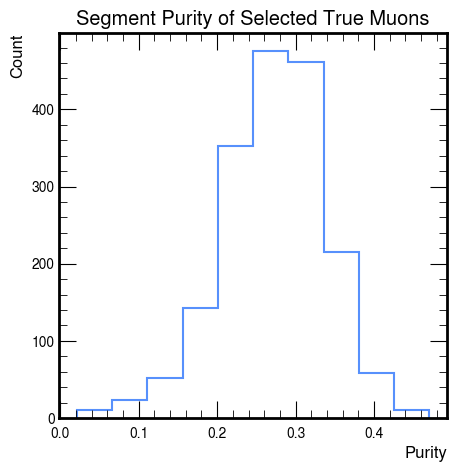

In [73]:
plt.style.use(hep.style.CMS)

plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize = (5,5))

ax.set_title('Segment Purity of Selected True Muons')
ax.set_xlabel('Purity')
ax.set_ylabel('Count')
h, bins = np.histogram(purity_segments, bins = 10)

hep.histplot(h,bins)
fig.show()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fd4981eba60>, errorbar=None, legend_artist=None)]

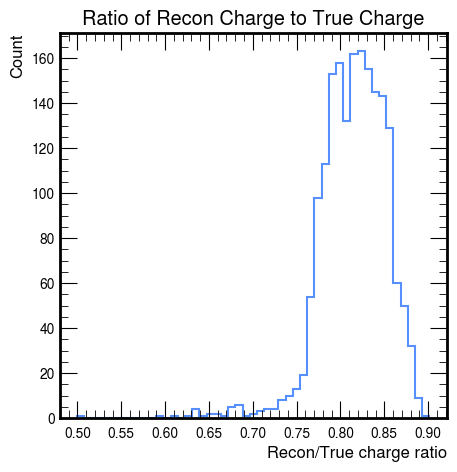

In [83]:
plt.style.use(hep.style.CMS)

plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize = (5,5))

ax.set_title('Ratio of Recon Charge to True Charge')
ax.set_xlabel('Recon/True charge ratio')
ax.set_ylabel('Count')

h, bins = np.histogram(energy_ratio, bins = np.linspace(np.min(energy_ratio), np.max(energy_ratio),50))

hep.histplot(h, bins)



In [75]:
pdgs_of_selection = []

for track in makeup:
    max_pdg = max(track, key = track.get)  # Get the max value directly using max()

    pdgs_of_selection.append(int(max_pdg))

In [76]:
type_of_particles = {
    "d": 1,
    "u": 2,
    "s": 3,
    "c": 4,
    "b": 5,
    "t": 6,
    "$e^-$": 11,
    "$e^+$": -11,
    "$\\nu_e$": 12,
    "$\\mu^-$": 13,
    "$\\mu^+$": -13,
    "$\\nu_\\mu$": 14,
    "$\\tau^-$": 15,
    "$\\nu_\\tau$": 16,
    "$\\tau'^-$": 17,
    "$\\nu_\\tau'$": 18,
    "$e^{*^-}$": 4000011,
    "$\\nu_e^*$": 4000012,
    "$\\mu^{*^-}$": 4000013,
    "$\\nu_\\mu^*$": 4000014,
    "$\\tau^{*^-}$": 4000015,
    "$\\nu_\\tau^*$": 4000016,
    "$g$": 21,
    "$\\pi^{+}$": 211,   # Pion Positive
    "$\\pi^{-}$": -211,  # Pion Negative
    "$\\pi^0$": 111,     # Pion Neutral
    "$p$": 2212,       # Proton
    "$n$": 2112,
    "$\\gamma$":22,
    "$K^+$": 321,        # Kaon Positive
    "$K^-$": -321,       # Kaon Negative
    "$K^0$": 311,        # Kaon Neutral
    "$\\bar{K}^0$": -311  # Kaon Anti-Neutral
}


In [77]:
particles = {}

percentages = [] 

unique_pdgs = np.unique(pdgs_of_selection)
unique_pdgs = np.array([int(pdg) for pdg in unique_pdgs])

for pdg in unique_pdgs:
    if pdg in type_of_particles.values():
        index = np.where(list(type_of_particles.values()) == pdg)[0][0]
        
        particle = list(type_of_particles.keys())[index]
        
        #Get amount of this particle
        amount, percent = amount_of_particle(pdg, pdgs_of_selection)
        
        particles.update({particle : amount})
        percentages.append(percent)
        
    else:
        particle = '{}'.format(pdg)
        #Get amount of this particle
        amount, percent = amount_of_particle(pdg, pdgs_of_selection)
        
        particles.update({particle : amount})
        percentages.append(percent)
        
    
#Get purity

muons = [pdg for pdg in pdgs_of_selection if pdg == 13 or pdg == -13]
print(percentages)

purity = round(len(muons)/len(pdgs_of_selection) * 100,2)
print(purity)

[1.03, 69.77, 0.11, 0.05, 27.79, 0.7, 0.54]
97.56


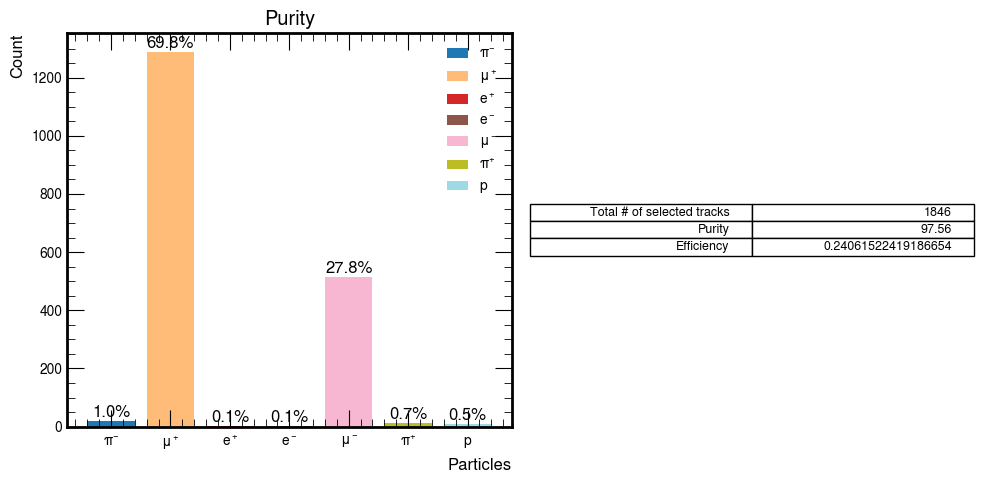

In [78]:
plt.style.use(hep.style.CMS)

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))

# Convert keys and values to lists for indexing
particle_list = list(particles.keys())
count_list = list(particles.values())

# Calculate percentages
total_count = sum(count_list)
percentages = [f'{(count / total_count) * 100:.1f}%' for count in count_list]

x = np.arange(len(particles))  # the label locations

# Define colormap
colormap = plt.get_cmap('tab20') 
colors = colormap(np.linspace(0, 1, len(particles)))

# Plot the bars and store references
bars = ax[0].bar(x, count_list, color = colors , tick_label=particle_list, label=particle_list)

# Loop through bars and add percentages
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax[0].text(
        bar.get_x() + bar.get_width() / 2, 
        height,  # Position the text slightly above the bar
        percentage,
        ha='center', 
        va='bottom'
    )

# Customize the plot
ax[0].set_xlabel('Particles')
ax[0].set_ylabel('Count')
ax[0].set_title('Purity')
ax[0].legend()


table_data = [['Total # of selected tracks', len(pdgs_of_selection)],['Purity',purity],['Efficiency', eff]]
ax[1].table(cellText=table_data, loc='center', fontsize = 8)
ax[1].axis('off')  # Hide axis
fig.tight_layout()
fig.show()

#fig.savefig('/global/cfs/cdirs/dune/users/demaross/MR5graphs/purityplot_PCA_{}_{}'.format(data_set, date.today()))

In [79]:
import numpy as np

# Assuming pdgs_of_selection and makeup are already defined
unique_pdgs = np.unique(pdgs_of_selection)

average_makeup = []

# Iterate over each unique PDG in selection
for i in range(len(unique_pdgs)):
    pdg = unique_pdgs[i]
    average_makeup_pdg = []
    unique_pdgs_of_makeup = set()
    
    # Collect dictionaries for the current PDG
    for track in makeup:
        if max(track, key=track.get) == str(pdg):
            average_makeup_pdg.append(track)

            # Collect unique keys in these dictionaries
            unique_pdgs_of_makeup.update(track.keys())
    print(unique_pdgs_of_makeup)
    
    # Add missing keys with 0 values
    for track in average_makeup_pdg:
        for key in unique_pdgs_of_makeup:
            if key not in track:
                track[key] = 0

    # Sum and average the values for each key
    sums = {}
    count = len(average_makeup_pdg)

    for d in average_makeup_pdg:
        for key, value in d.items():
            sums[key] = sums.get(key, 0) + value

    averages = {key: value / count for key, value in sums.items()}
    average_makeup.append(averages)

# average_makeup now contains the averaged makeup for each unique PDG


{'1000010020', '3112', '1000160350', '13', '22', '1000180400', '11', '2212', '2112', '-13', '-11', '1000170389', '1000160330', '-211'}
{'1000010020', '-321', '3112', '13', '211', '22', '1000180400', '11', '2212', '2112', '-13', '1000180390', '-11', '1000140290', '1000020040', '1000160360', '-211'}
{'11', '2112', '22', '-11'}
{'11', '22'}
{'1000010020', '1000170400', '13', '211', '22', '1000180400', '11', '2112', '2212', '-13', '-11', '-211'}
{'1000010020', '1000010030', '1000160350', '211', '1000160340', '22', '1000140300', '1000180400', '11', '2212', '2112', '-13', '1000180390', '-11', '1000020040', '-211'}
{'1000010020', '13', '1000160370', '22', '1000180400', '2112', '11', '2212', '-11', '1000180380', '-211'}


In [80]:
ind = []
for pdg in unique_pdgs:
    if pdg in type_of_particles.values():
        index = np.where(list(type_of_particles.values()) == pdg)[0][0]
        
        particle = list(type_of_particles.keys())[index]
    
        ind.append('True ' + particle)
    else:
        particle = 'True {}'.format(pdg)


        

In [81]:
def highlight_zeros(val):
    color = 'white' if val == 0 else ''  # Highlight zeros with white color
    return f'background-color: {color}'

df1 = pd.DataFrame(average_makeup, index= ind)
df1 = df1.fillna(0)
df1.index.name = 'Selected'
df1.columns.name = 'Average Energy Makeup'

new_columns = {}
# Convert dictionary values to a list
values_list = list(type_of_particles.values())
keys_list = list(type_of_particles.keys())


# Iterate over DataFrame columns
for i in range(len(df1.columns)):
    column_value = int(df1.columns[i])  # Convert column name to integer
    if column_value in values_list:
        pindex = values_list.index(column_value)
        new_columns[df1.columns[i]] = keys_list[pindex]
        
    else:
        new_columns[df1.columns[i]] = df1.columns[i]

particles_not_in_type_indices = np.where(np.isin(np.array(df1.columns, dtype = int),values_list,invert = True))

particle_types_not_found = df1.columns[particles_not_in_type_indices]

particles_in_type_indices = np.where(np.isin(np.array(df1.columns, dtype = int),values_list))

particle_types_found = df1.columns[particles_in_type_indices]

df_combined = df1[particle_types_not_found].sum(axis=1)
df1 = df1[particle_types_found]

df1['else'] = df_combined

df1.rename(columns=new_columns,inplace = True)

index_to_rearrange = []

for index in df1.index:
     index_to_rearrange.append(index[5:])
        
rows_not_found_indices = np.where(np.isin(df1.columns,index_to_rearrange, invert = True))
selected_not_found = df1.columns[rows_not_found_indices]

for not_selected in selected_not_found:
    df1.loc[len(df1)] = 0
    df1 = df1.rename(index={df1.index[-1]:'True ' + not_selected})

column_titles = []

for index in df1.index:
    column_titles.append(np.where(df1.columns == index[5:])[0])

df1 = df1.iloc[:,np.concatenate(column_titles)]
styled_df = df1.style.background_gradient(cmap='Blues').highlight_max(axis=1, color='blue').format(precision = 6).applymap(highlight_zeros)

styled_df

/tmp/ipykernel_1121201/3505752307.py:59: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df1.style.background_gradient(cmap='Blues').highlight_max(axis=1, color='blue').format(precision = 6).applymap(highlight_zeros)


Average Energy Makeup,$\pi^{-}$,$\mu^+$,$e^+$,$e^-$,$\mu^-$,$\pi^{+}$,$p$,$\gamma$,$n$,$K^-$,else
Selected,,,,,,,,,,,
True $\pi^{-}$,0.946485,0.003489,0.002895,0.002662,0.011162,0.000000,0.019090,0.000038,0.000004,0.000000,0.014176
True $\mu^+$,0.000607,0.992135,0.004277,0.001047,0.000362,0.000073,0.001283,0.000013,0.000007,0.000056,0.000139
True $e^+$,0.000000,0.000000,0.983717,0.008685,0.000000,0.000000,0.000000,0.000413,0.007184,0.000000,0.000000
True $e^-$,0.000000,0.000000,0.000000,0.999653,0.000000,0.000000,0.000000,0.000347,0.000000,0.000000,0.000000
True $\mu^-$,0.000102,0.001599,0.004820,0.000988,0.990539,0.000482,0.001348,0.000012,0.000010,0.000000,0.000100
True $\pi^{+}$,0.023589,0.002958,0.029757,0.011333,0.000000,0.815265,0.053382,0.000025,0.000057,0.000000,0.063635
True $p$,0.008935,0.000000,0.029974,0.001403,0.008860,0.000000,0.935547,0.000016,0.000028,0.000000,0.015238
True $\gamma$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
True $n$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
